In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import davies_bouldin_score, silhouette_score

<h1 style="color:red">Baseline Pipiline</h1>

In [24]:
# Load Data
def Load_data():
    iris = load_iris()
    data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
    data.head()
    return data

In [25]:
# Data Cleaning
def CleanFunc(data):
    # Impute missing values (mean/mode imputation)
    for column in data.columns:
        if data[column].dtype == 'object':
            # Use mode for categorical columns
            data[column].fillna(data[column].mode()[0], inplace=True)
        else:
            #  mean for numerical columns
            data[column].fillna(data[column].mean(), inplace=True)
    print(f"Data after imputing missing values: {data.shape}")
    
    # One-hot encoding for categorical variables
    categorical_cols = data.select_dtypes(include=['object']).columns
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    
    return data

## Preprocessing steps all in one fucnions

In [26]:
def preprocessing(data,columns,dropna=False,replace_outliers=False,scale=False,target=None,):

#Drop columns with missing values greater than 40% of total values
    cols = data.columns[data.isna().sum() * 100 / len(data) > 40]
    data.drop(columns=cols, axis=1, inplace=True)
    print(f"Dropped columns with more than 40% missing values: {list(cols)}")

    if target:
        # Drop any row in target with missing values
        initial_rows = data.shape[0]
        data.drop(data[data[target].isna()].index, inplace=True)
        dropped_rows = initial_rows - data.shape[0]
        print(f"Dropped {dropped_rows} rows with missing target values.")

    if dropna:
        # Drop any row with missing values
        initial_rows = data.shape[0]
        data.dropna(inplace=True)
        dropped_rows = initial_rows - data.shape[0]
        print(f"Dropped {dropped_rows} rows with missing values.")

    if replace_outliers:
        outliers_replaced = 0
        for col in columns:
            # Skip categorical columns (if any)
            if data[col].dtype == object:
                continue
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            # Replace outliers with Minimum and Maximum values
            before_outliers = data[col].isna().sum()
            data[col] = np.where(
                data[col] < (Q1 - (1.5 * IQR)),
                Q1 - 1.5 * IQR,
                np.where(data[col] > (Q3 + (1.5 * IQR)), Q3 + (1.5 * IQR), data[col]),
            )
            after_outliers = data[col].isna().sum()
            outliers_replaced += before_outliers - after_outliers
        data.fillna(0, inplace=True)
        print(f"Replaced {outliers_replaced} outliers.")

    if scale:
        numerical_columns = split_categorical_and_numeric(data)[1]
        # Scale the data such that all columns are in the range 0 to 1
        scaler = StandardScaler()
        data[numerical_columns] = scaler.fit_transform(
            data[numerical_columns]
        )  # Scaling and normalizing numerical data
        print(f"Scaled columns: {columns}")

    return data


In [28]:
def split_categorical_and_numeric(data):
    cat_columns = []
    num_columns = []
    col = data.columns
    for i in col:
        if data[i].dtypes == object:
            cat_columns.append(i)
        elif data[i].dtypes == float:
            num_columns.append(i)
        elif data[i].dtypes == int:
            num_columns.append(i)
    return cat_columns, num_columns

# One-Hot Encoding

In [30]:
def encode_categorical(df: pd.DataFrame, cat_cols, encoding_type) -> pd.DataFrame:
    if not cat_cols:
        cat_cols, _ = split_categorical_and_numeric(df)
    if encoding_type == "onehot":
        df = pd.get_dummies(df, columns=cat_cols)
    elif encoding_type == "label":
        LE = LabelEncoder()
        for col in cat_cols:
            df[col] = df[[col]].apply(LE.fit_transform)
    return df

# Dendrogram

In [31]:
def plot_dendogram(df):
    linkage_matrix = linkage(df, method="ward")

    plt.figure(figsize=(50, 30))
    dendrogram(linkage_matrix)
    plt.title("Agg. Hierarchical Clustering Dendogram (Single Linkage)")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")

# Correlation Heatmap

In [32]:
def plot_correlation_matrix(df, figsize=(12, 12)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

    print("Descriptive Statistics:")
    print(df.describe())

# TSNE & PCA Analysis

In [33]:
def plot_PCA_TSNE(df: pd.DataFrame):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    _df = df.copy()
    _df["PCA1"] = pca_result[:, 0]
    _df["PCA2"] = pca_result[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PCA1", y="PCA2", data=_df)

    plt.title("PCA")
    plt.show()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(df)
    _df["TSNE1"] = tsne_result[:, 0]
    _df["TSNE2"] = tsne_result[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="TSNE1", y="TSNE2", data=_df)
    
    plt.title("t-SNE")
    plt.show()

    return pca_result, tsne_result, _df

# Reachability Plot

In [34]:
def plot_reachability(optics):
    space = np.arange(len(optics.ordering_))
    reachability = optics.reachability_[optics.ordering_]
    labels = optics.labels_[optics.ordering_]

    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", np.unique(labels).max() + 1)
    for klass, color in zip(range(0, np.unique(labels).max() + 1), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        plt.plot(
            Xk,
            Rk,
            "o",
            markerfacecolor=color,
            markeredgecolor="k",
            markersize=5,
            alpha=0.5,
        )
    plt.plot(
        space[labels == -1],
        reachability[labels == -1],
        "o",
        markerfacecolor="k",
        markeredgecolor="k",
        markersize=5,
        alpha=0.5,
    )
    plt.ylabel("Reachability (epsilon distance)")
    plt.title("Reachability Plot")
    plt.show()

# DBSCAN Function

In [35]:
def run_dbscan(df_pca, eps_values, min_samples_values):
    num_eps = len(eps_values)
    num_min_samples = len(min_samples_values)

    fig, axes = plt.subplots(num_eps, num_min_samples, figsize=(15, 10))

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(df_pca)

            sns.scatterplot(
                x=df_pca.iloc[:, 0],
                y=df_pca.iloc[:, 1],
                hue=clusters,
                palette="viridis",
                ax=axes[i, j],
            )
            axes[i, j].set_title(f"eps={eps}, min_samples={min_samples}")
            axes[i, j].legend([], frameon=False)  # Optional: Hide legend in subplots

    plt.tight_layout()
    plt.show()

# OPTICS Fucntion

In [36]:
def run_optics(df_pca, min_samples, max_eps):
    optics = OPTICS(min_samples=min_samples, max_eps=max_eps)
    clusters = optics.fit_predict(df_pca)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], hue=clusters, palette="viridis"
    )
    plt.title(f"OPTICS Clustering (min_samples={min_samples}, max_eps={max_eps})")
    plt.show()


def run_optics(df_pca, min_samples_values, max_eps_values):
    num_min_samples = len(min_samples_values)
    num_max_eps = len(max_eps_values)

    fig, axes = plt.subplots(num_min_samples, num_max_eps, figsize=(15, 10))

    for i, min_samples in enumerate(min_samples_values):
        for j, max_eps in enumerate(max_eps_values):
            optics = OPTICS(min_samples=min_samples, max_eps=max_eps)
            clusters = optics.fit_predict(df_pca)

            sns.scatterplot(
                x=df_pca.iloc[:, 0],
                y=df_pca.iloc[:, 1],
                hue=clusters,
                palette="viridis",
                ax=axes[i, j],
            )
            axes[i, j].set_title(f"min_samples={min_samples}, max_eps={max_eps}")
            axes[i, j].legend([], frameon=False)  # Optional: Hide legend in subplots

    plt.tight_layout()
    plt.show()

<h1 style="color:green">Calling all Function Sequentially </h1>

In [37]:
data = Load_data()
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


# Data Cleaning fucntion calling

In [38]:
clean_data = CleanFunc(data)
clean_data

Data after imputing missing values: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


# Preprocessing steps exectution

In [39]:
data = preprocessing(data, data.columns, dropna=True, replace_outliers=True, scale=True)
data.head()

Dropped columns with more than 40% missing values: []
Dropped 0 rows with missing values.
Replaced 0 outliers.
Scaled columns: Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.051961,-1.340227,-1.315444
1,-1.143017,-0.127367,-1.340227,-1.315444
2,-1.385353,0.344364,-1.397064,-1.315444
3,-1.506521,0.108498,-1.283389,-1.315444
4,-1.021849,1.287827,-1.340227,-1.315444


In [40]:
data = encode_categorical(data, None, encoding_type='label')
data.dropna(inplace=True)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.051961,-1.340227,-1.315444
1,-1.143017,-0.127367,-1.340227,-1.315444
2,-1.385353,0.344364,-1.397064,-1.315444
3,-1.506521,0.108498,-1.283389,-1.315444
4,-1.021849,1.287827,-1.340227,-1.315444


# Correlation analysis

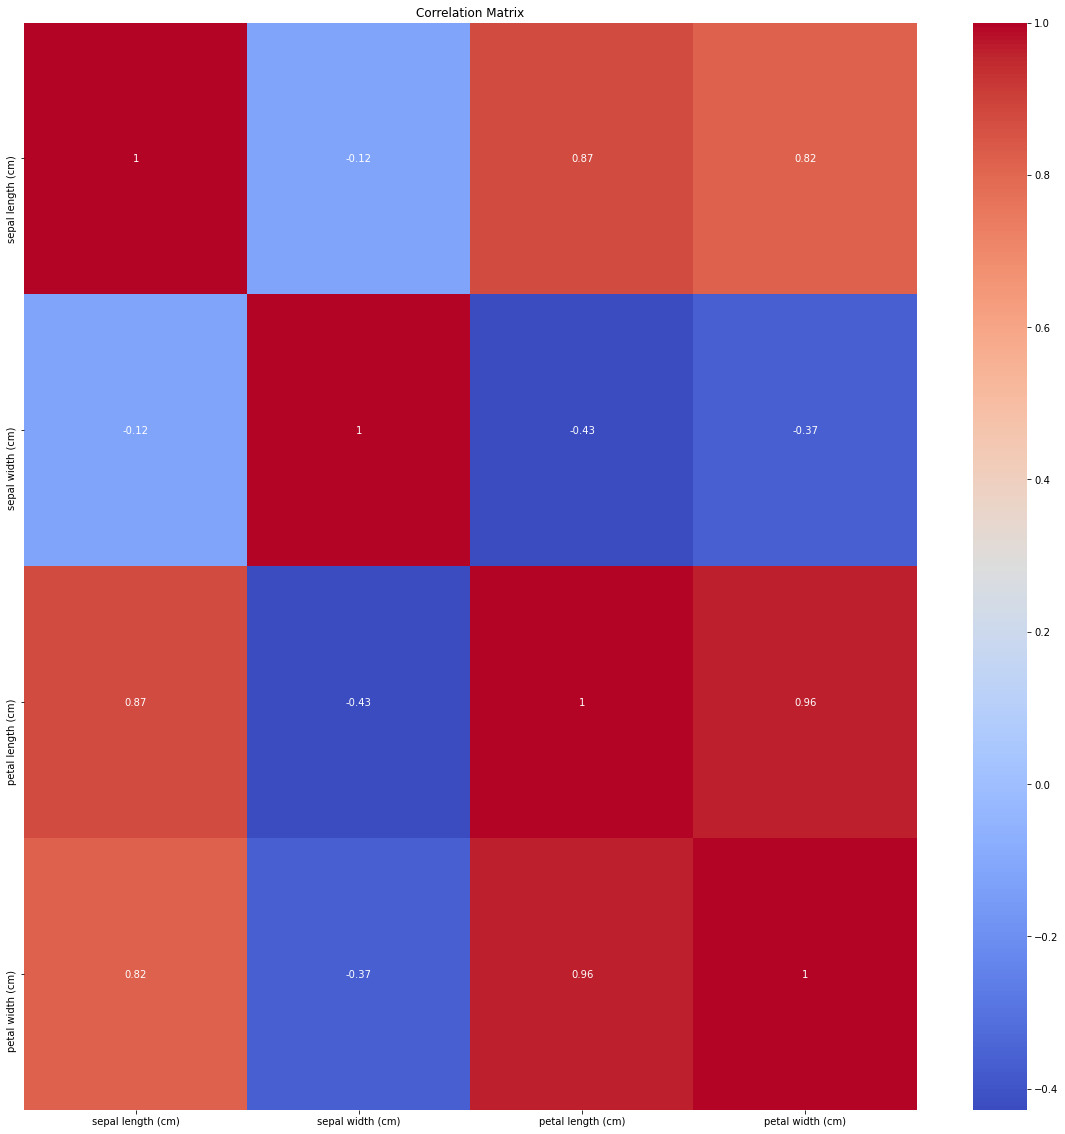

Descriptive Statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count       1.500000e+02      1.500000e+02       1.500000e+02   
mean       -4.736952e-16     -6.158037e-16      -4.263256e-16   
std         1.003350e+00      1.003350e+00       1.003350e+00   
min        -1.870024e+00     -2.368091e+00      -1.567576e+00   
25%        -9.006812e-01     -5.990988e-01      -1.226552e+00   
50%        -5.250608e-02     -1.273675e-01       3.364776e-01   
75%         6.745011e-01      5.802296e-01       7.627583e-01   
max         2.492019e+00      2.349222e+00       1.785832e+00   

       petal width (cm)  
count      1.500000e+02  
mean      -4.736952e-16  
std        1.003350e+00  
min       -1.447076e+00  
25%       -1.183812e+00  
50%        1.325097e-01  
75%        7.906707e-01  
max        1.712096e+00  


In [42]:
plot_correlation_matrix(data, figsize=(20,20))

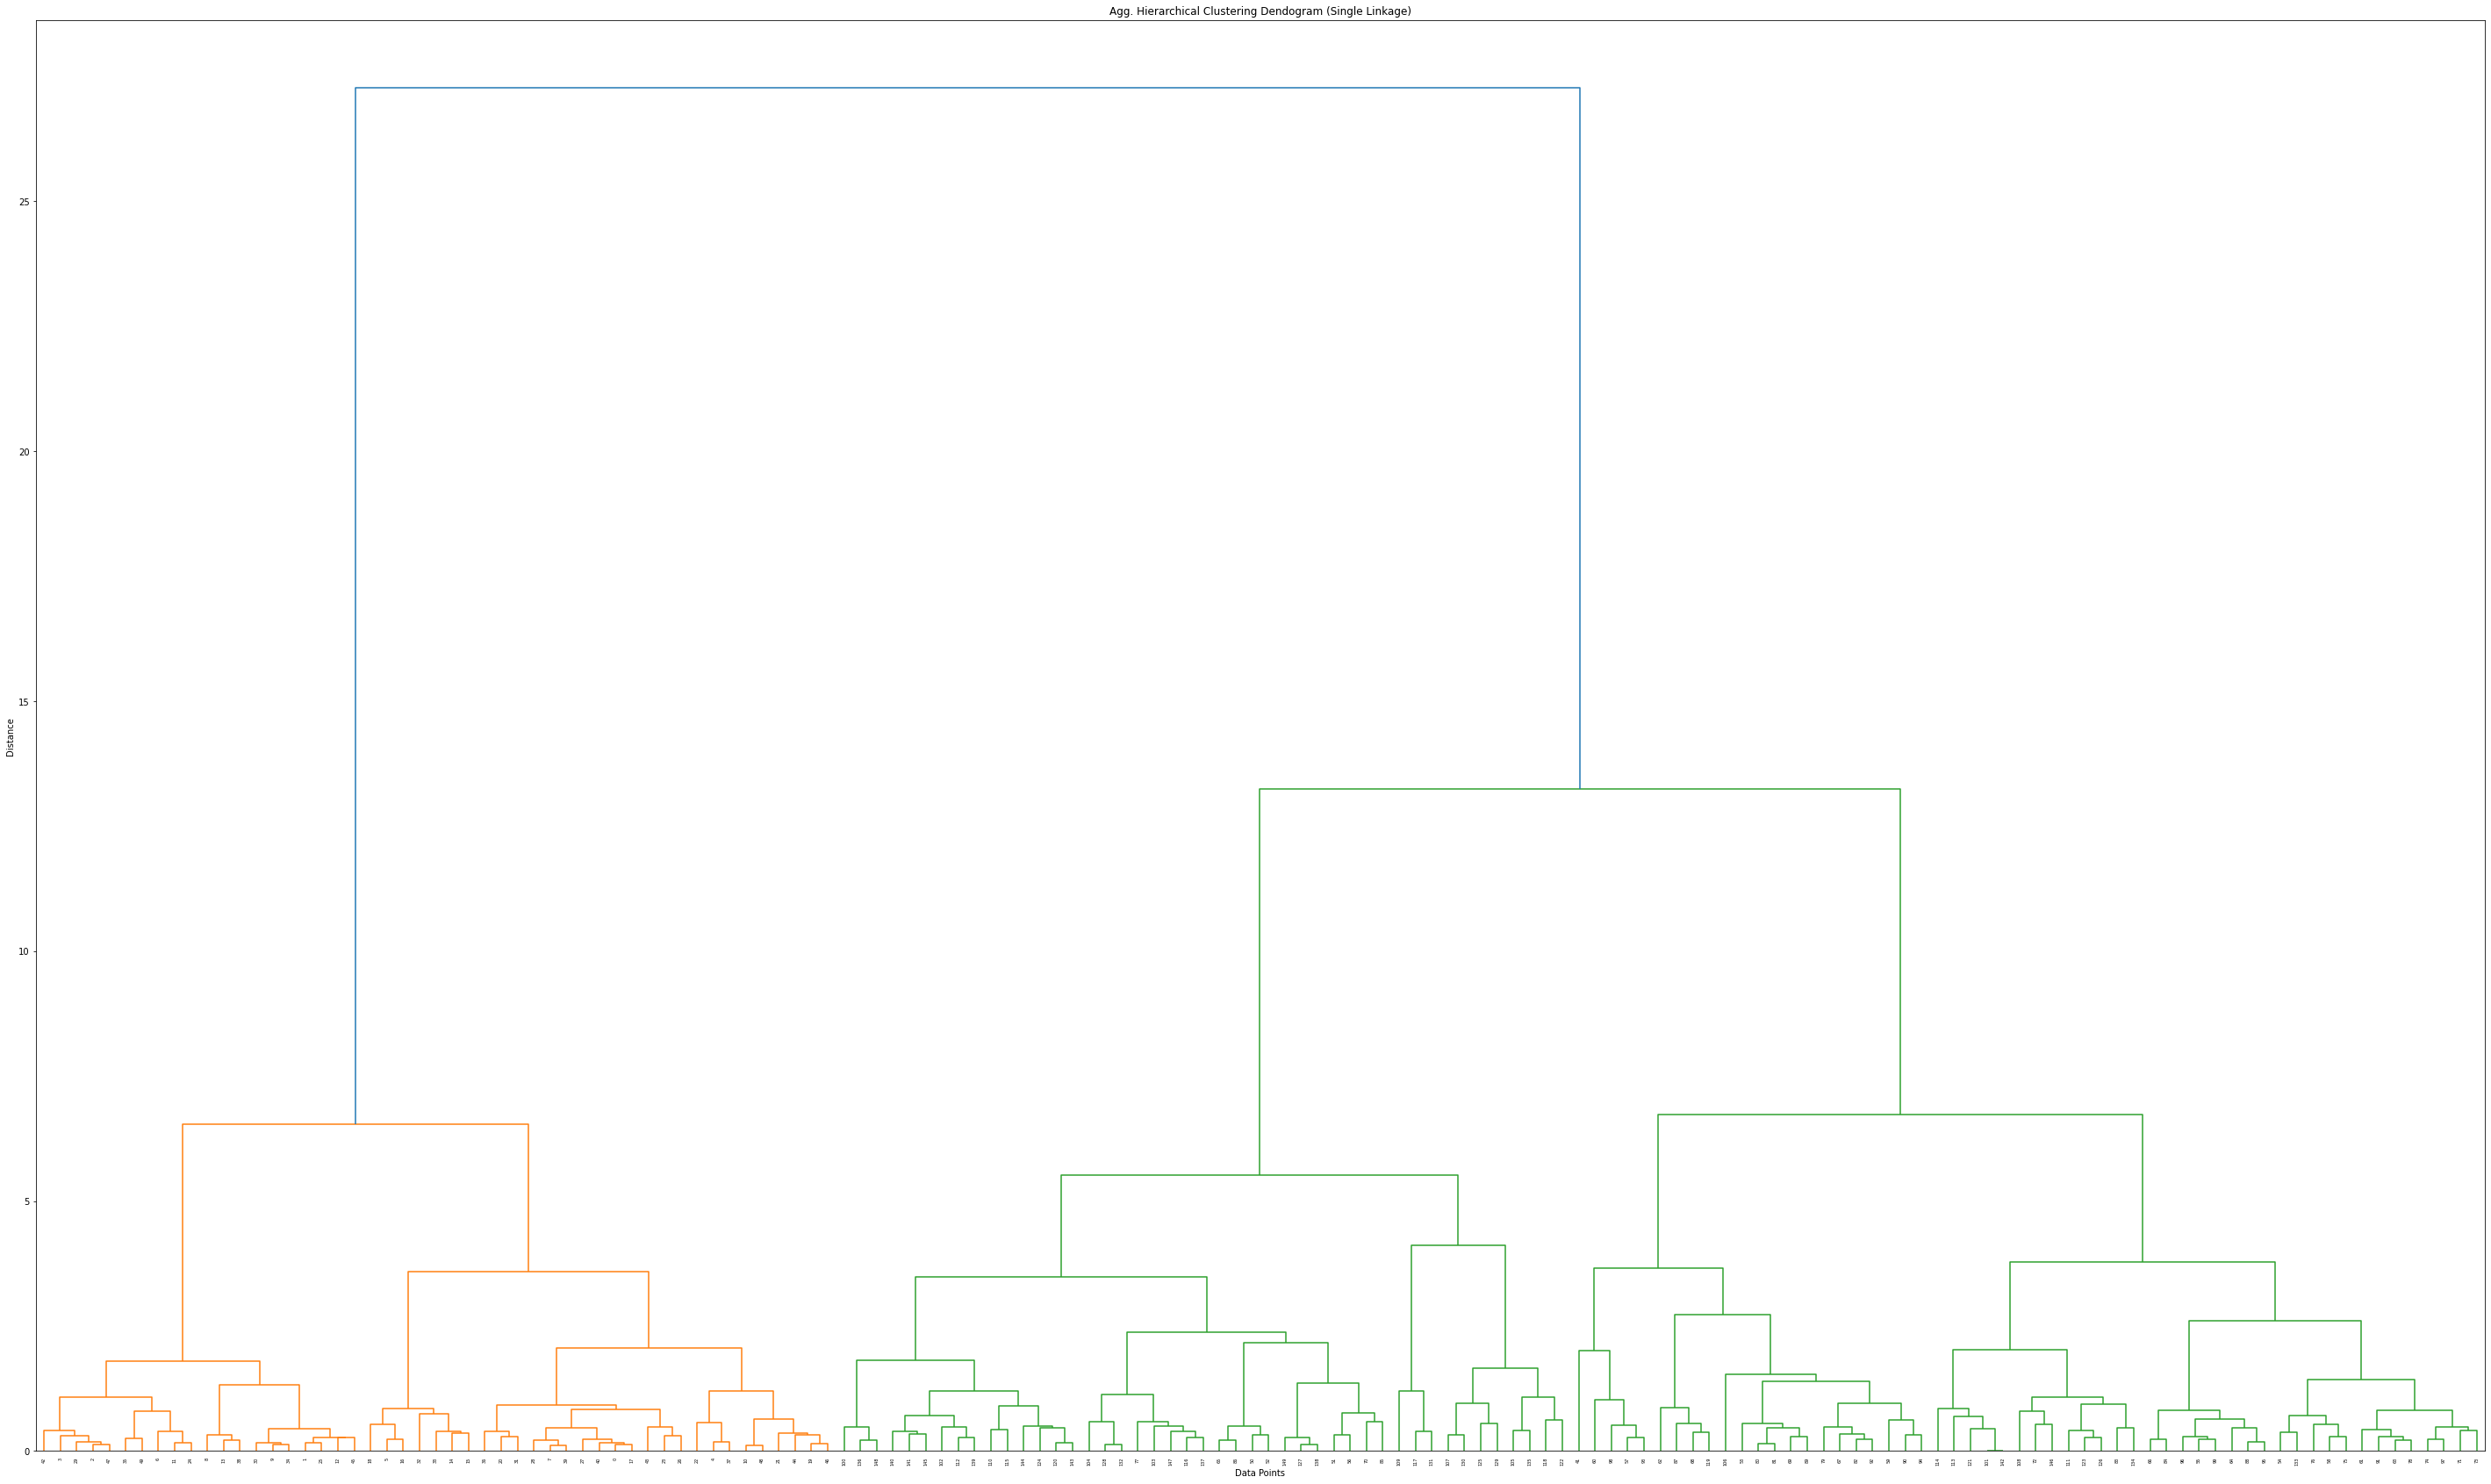

In [43]:
plot_dendogram(data)

In [44]:
pca = PCA(n_components=2)
pca.fit(data)
data_pca = pd.DataFrame(pca.transform(data), columns=(["col1","col2"]))

tsne = TSNE(n_components=2, random_state=42)
data_tsne = pd.DataFrame(tsne.fit_transform(data), columns=["col1", "col2"])

data_pca.head()

C:\Users\mkami\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mkami\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,col1,col2
0,-2.273496,0.510565
1,-2.082263,-0.669996
2,-2.368575,-0.326792
3,-2.302246,-0.587421
4,-2.400157,0.682873


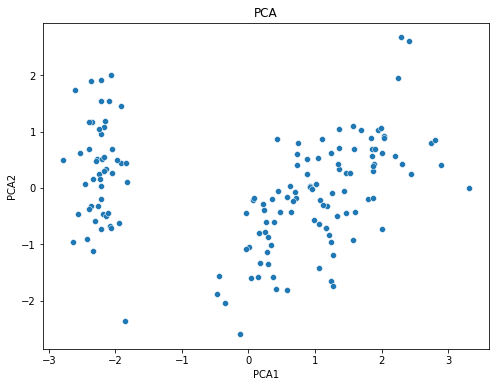

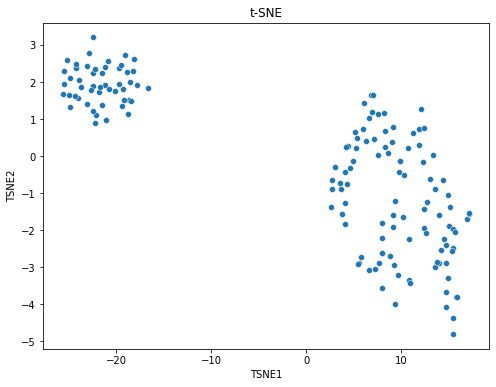

(array([[-2.27349551e+00,  5.10564843e-01],
        [-2.08226325e+00, -6.69995686e-01],
        [-2.36857455e+00, -3.26792310e-01],
        [-2.30224576e+00, -5.87421176e-01],
        [-2.40015748e+00,  6.82873431e-01],
        [-2.09041188e+00,  1.54088757e+00],
        [-2.45141128e+00,  7.37273025e-02],
        [-2.24015407e+00,  2.48522175e-01],
        [-2.33452494e+00, -1.11574792e+00],
        [-2.18712985e+00, -4.59614046e-01],
        [-2.17806238e+00,  1.08446553e+00],
        [-2.33347460e+00,  1.58788096e-01],
        [-2.21976312e+00, -7.24484319e-01],
        [-2.63449490e+00, -9.56595428e-01],
        [-2.21493275e+00,  1.91616747e+00],
        [-2.06218680e+00,  2.00160558e+00],
        [-2.22236130e+00,  1.53523236e+00],
        [-2.19914958e+00,  5.19479535e-01],
        [-1.91178795e+00,  1.45081217e+00],
        [-2.35668632e+00,  1.17454093e+00],
        [-1.92156359e+00,  4.33645541e-01],
        [-2.21883237e+00,  9.65573088e-01],
        [-2.78472267e+00,  4.949

In [45]:
plot_PCA_TSNE(data_pca)

<h1 style="color:red">DBSCAN Fucntion calling</h1>

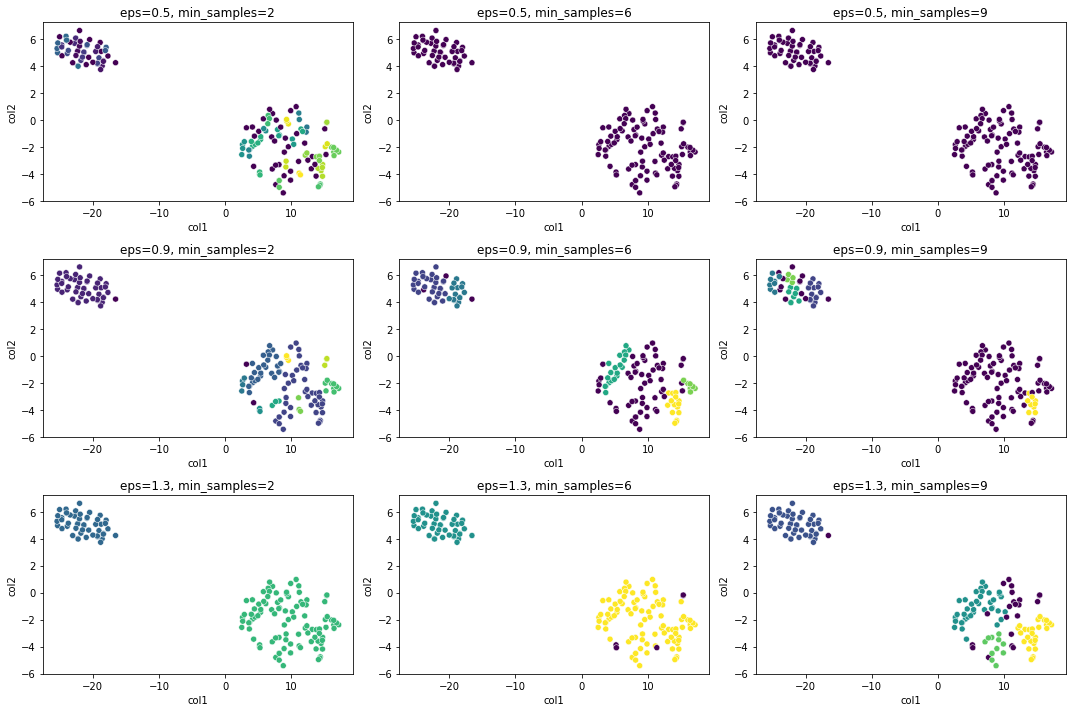

In [46]:
eps_values = [0.5, 0.9, 1.3]
min_samples_values = [2, 6, 9]
run_dbscan(data_tsne, eps_values, min_samples_values)

<h1 style="color:red">OPTICS Fucntion calling</h1>

C:\Users\mkami\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:631: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
C:\Users\mkami\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:631: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
C:\Users\mkami\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:631: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


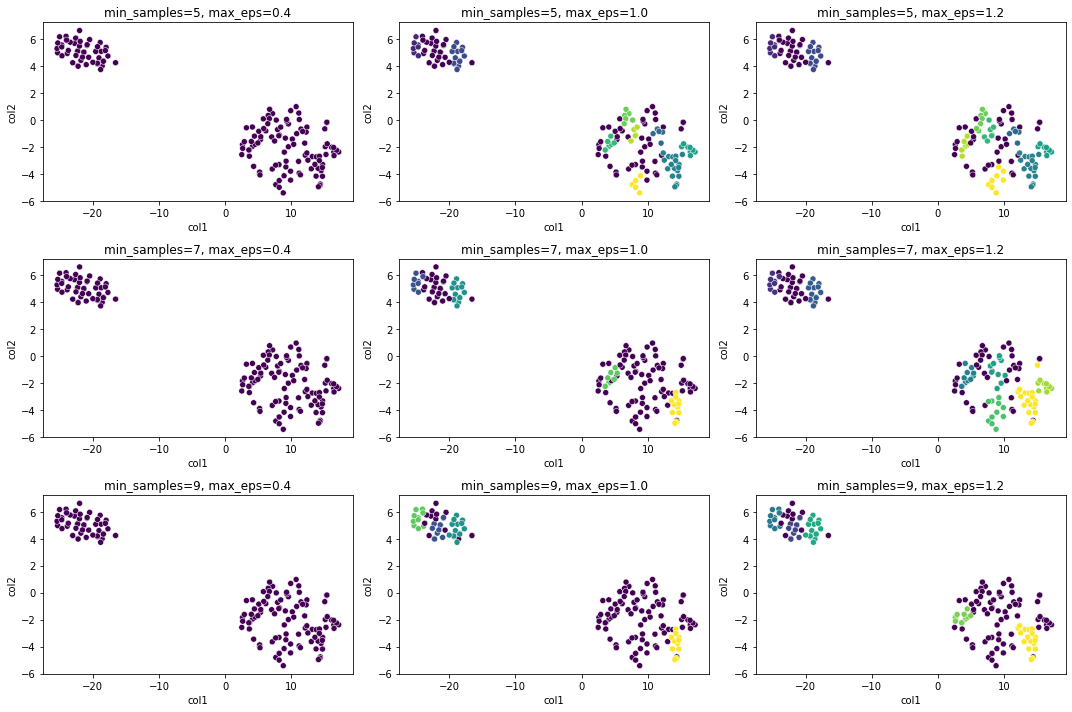

In [47]:
max_eps_values = [0.4, 1.0, 1.2]
min_samples_values = [5, 7, 9]
run_optics(data_tsne, min_samples_values, max_eps_values)

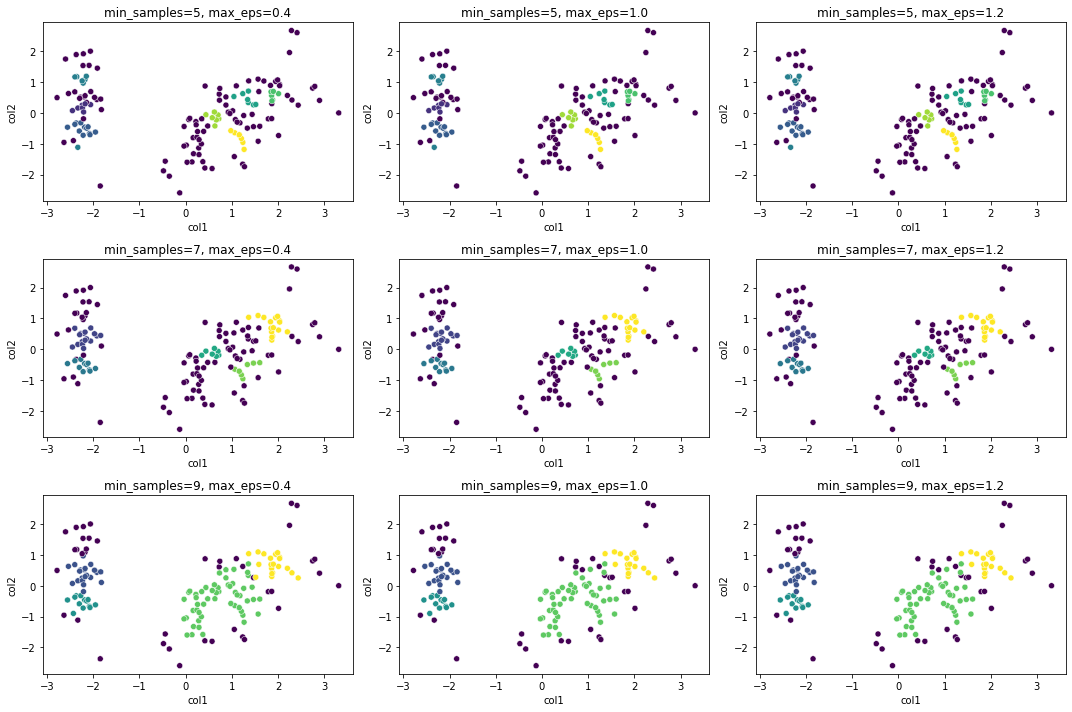

In [49]:
max_eps_values = [0.4, 1.0, 1.2]
min_samples_values = [5, 7, 9]
run_optics(data_pca, min_samples_values, max_eps_values)

<h1 style="color:blue">Reachability Plot</h1>

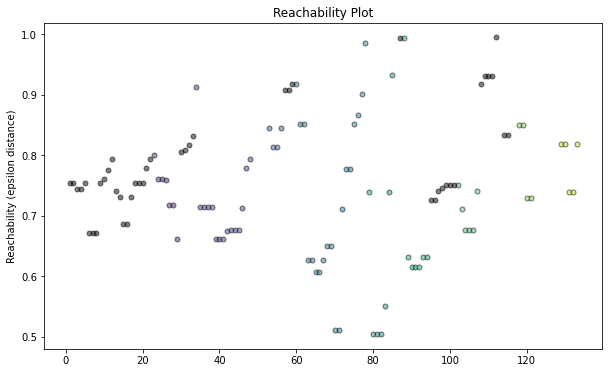

In [48]:
optics = OPTICS(min_samples=5, max_eps=1).fit(data_tsne)
plot_reachability(optics)

# Interpretation on Word File